In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load the datasets
admissions_df = pd.read_csv('admissions.csv')
fatalities_df = pd.read_csv('fatalities.csv')
smokers_df = pd.read_csv('smokers.csv')
prescriptions_df = pd.read_csv('prescriptions.csv')
metrics_df = pd.read_csv('metrics.csv')

In [4]:
# Preprocess admissions and fatalities
admissions_df['Value'] = pd.to_numeric(admissions_df['Value'], errors='coerce')
fatalities_df['Value'] = pd.to_numeric(fatalities_df['Value'], errors='coerce')
admissions_df['Sex'] = admissions_df['Sex'].fillna('Unknown')
fatalities_df['Sex'] = fatalities_df['Sex'].fillna('Unknown')
admissions_df['Year'] = admissions_df['Year'].str.extract(r'(\d{4})').astype(float)
fatalities_df['Year'] = fatalities_df['Year'].astype(float)

# Process smokers dataset
smokers_df['Total Prevalence'] = smokers_df.iloc[:, 3:].sum(axis=1) / 7
smokers_df.rename(columns={'16 and Over': 'Prevalence 16+', '60 and Over': 'Prevalence 60+'}, inplace=True)


In [5]:
# Ensure the Year column is of string type before extracting the year
def extract_year(year_column):
    """Extract the first 4 digits from the Year column."""
    return year_column.astype(str).str.extract(r'(\d{4})').astype(float)

# Apply the function to extract Year
admissions_df['Year'] = extract_year(admissions_df['Year'])
fatalities_df['Year'] = extract_year(fatalities_df['Year'])
prescriptions_df['Year'] = extract_year(prescriptions_df['Year'])
metrics_df['Year'] = extract_year(metrics_df['Year'])

# If Smokers dataset already has clean numeric years, convert to float
smokers_df['Year'] = smokers_df['Year'].astype(float)


In [6]:
# Merge admissions and fatalities
merged_df = pd.merge(
    admissions_df,
    fatalities_df,
    on=['Year', 'ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric', 'Sex'],
    suffixes=('_admissions', '_fatalities'),
    how='inner'
)

# Merge with smokers
final_df = pd.merge(
    merged_df,
    smokers_df[['Year', 'Total Prevalence', 'Prevalence 16+', 'Prevalence 60+']],
    on='Year',
    how='left'
)

# Merge with prescriptions and metrics datasets
prescriptions_df['Year'] = prescriptions_df['Year'].astype(float)
metrics_df['Year'] = metrics_df['Year'].astype(float)
final_df = pd.merge(final_df, prescriptions_df, on='Year', how='left')
final_df = pd.merge(final_df, metrics_df, on='Year', how='left')

In [7]:
# Feature Engineering
final_df["Admission_Fatality_Ratio"] = final_df["Value_admissions"] / final_df["Value_fatalities"]
final_df["Cost_Per_Prescription"] = (
    final_df["Net Ingredient Cost of All Pharmacotherapies"]
    / final_df["All Pharmacotherapy Prescriptions"]
)

# Drop rows with missing data for analysis
final_df_cleaned = final_df.dropna()


In [11]:
print(final_df_cleaned.dtypes)


Year                                                           float64
ICD10 Code                                                      object
ICD10 Diagnosis                                                 object
Diagnosis Type                                                  object
Metric                                                          object
Sex                                                             object
Value_admissions                                               float64
Value_fatalities                                               float64
Total Prevalence                                               float64
Prevalence 16+                                                   int64
Prevalence 60+                                                   int64
All Pharmacotherapy Prescriptions                                int64
Nicotine Replacement Therapy (NRT) Prescriptions                 int64
Bupropion (Zyban) Prescriptions                                  int64
Vareni

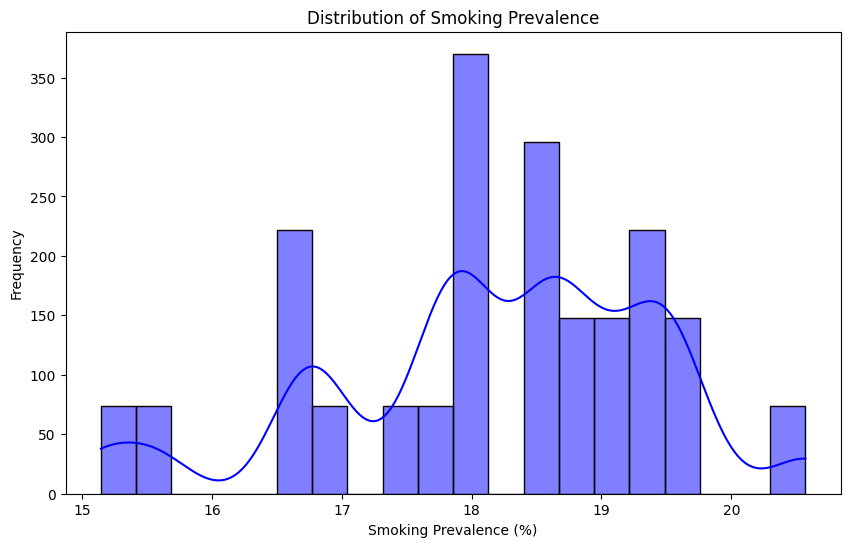

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(final_df_cleaned["Total Prevalence"], bins=20, kde=True, color="blue")
plt.title("Distribution of Smoking Prevalence")
plt.xlabel("Smoking Prevalence (%)")
plt.ylabel("Frequency")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12996\1376436935.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df_cleaned, x="Year", y="Tobacco Price\nIndex", palette="coolwarm")


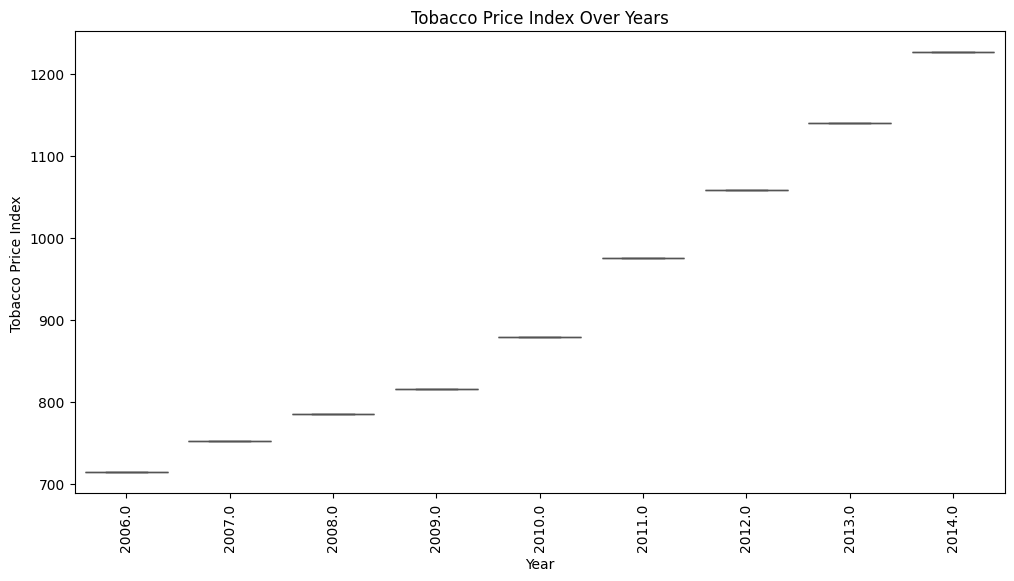

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df_cleaned, x="Year", y="Tobacco Price\nIndex", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Tobacco Price Index Over Years")
plt.xlabel("Year")
plt.ylabel("Tobacco Price Index")
plt.show()


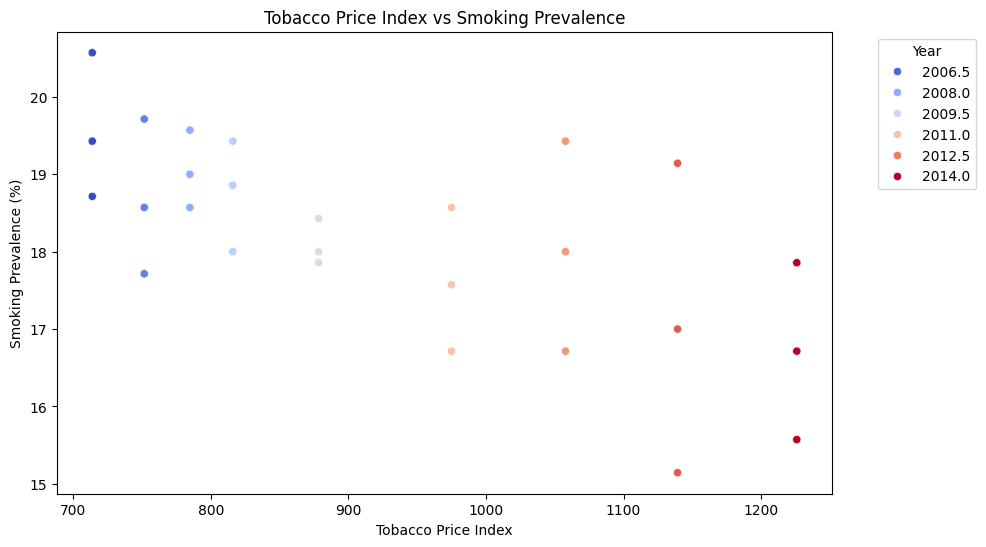

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df_cleaned, x="Tobacco Price\nIndex", y="Total Prevalence", hue="Year", palette="coolwarm")
plt.title("Tobacco Price Index vs Smoking Prevalence")
plt.xlabel("Tobacco Price Index")
plt.ylabel("Smoking Prevalence (%)")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


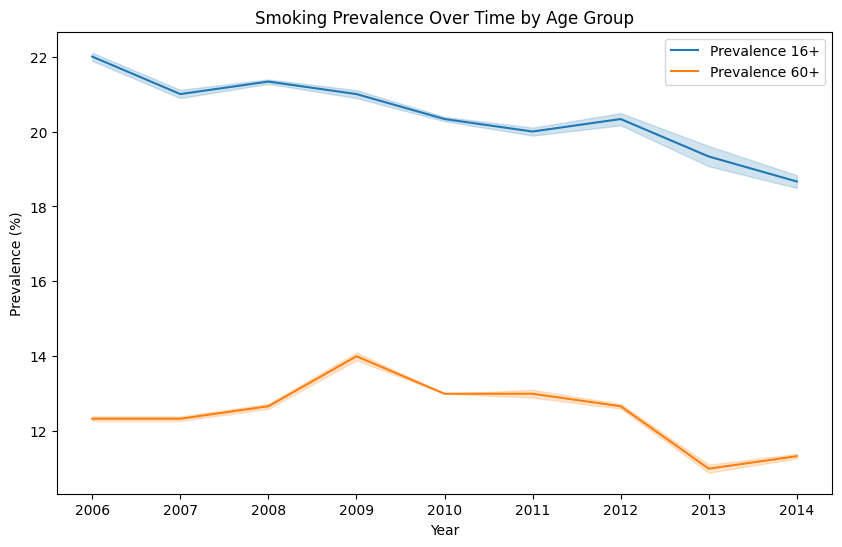

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df_cleaned, x="Year", y="Prevalence 16+", label="Prevalence 16+")
sns.lineplot(data=final_df_cleaned, x="Year", y="Prevalence 60+", label="Prevalence 60+")
plt.title("Smoking Prevalence Over Time by Age Group")
plt.xlabel("Year")
plt.ylabel("Prevalence (%)")
plt.legend()
plt.show()


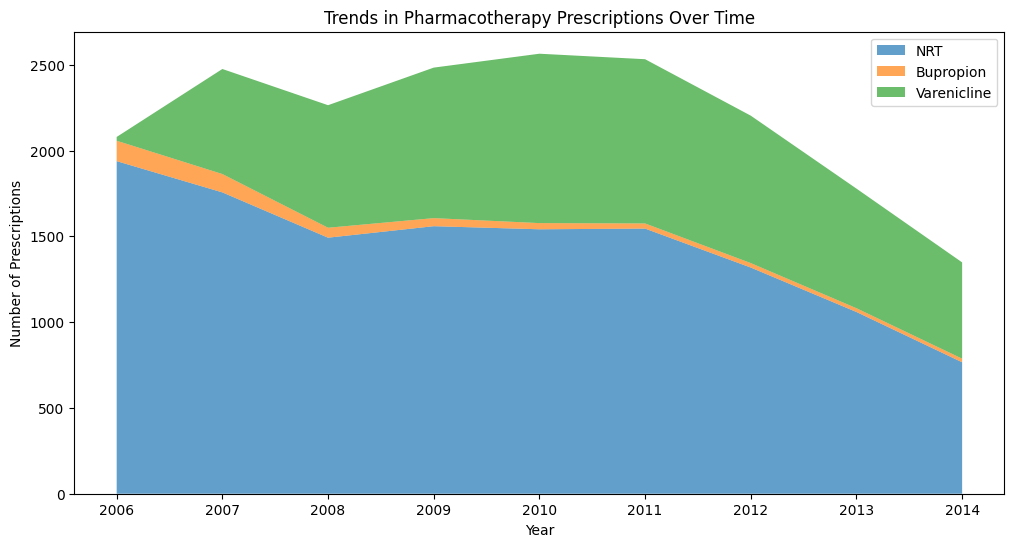

In [18]:
plt.figure(figsize=(12, 6))
plt.stackplot(
    final_df_cleaned["Year"],
    final_df_cleaned["Nicotine Replacement Therapy (NRT) Prescriptions"],
    final_df_cleaned["Bupropion (Zyban) Prescriptions"],
    final_df_cleaned["Varenicline (Champix) Prescriptions"],
    labels=["NRT", "Bupropion", "Varenicline"],
    alpha=0.7
)
plt.title("Trends in Pharmacotherapy Prescriptions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Prescriptions")
plt.legend()
plt.show()


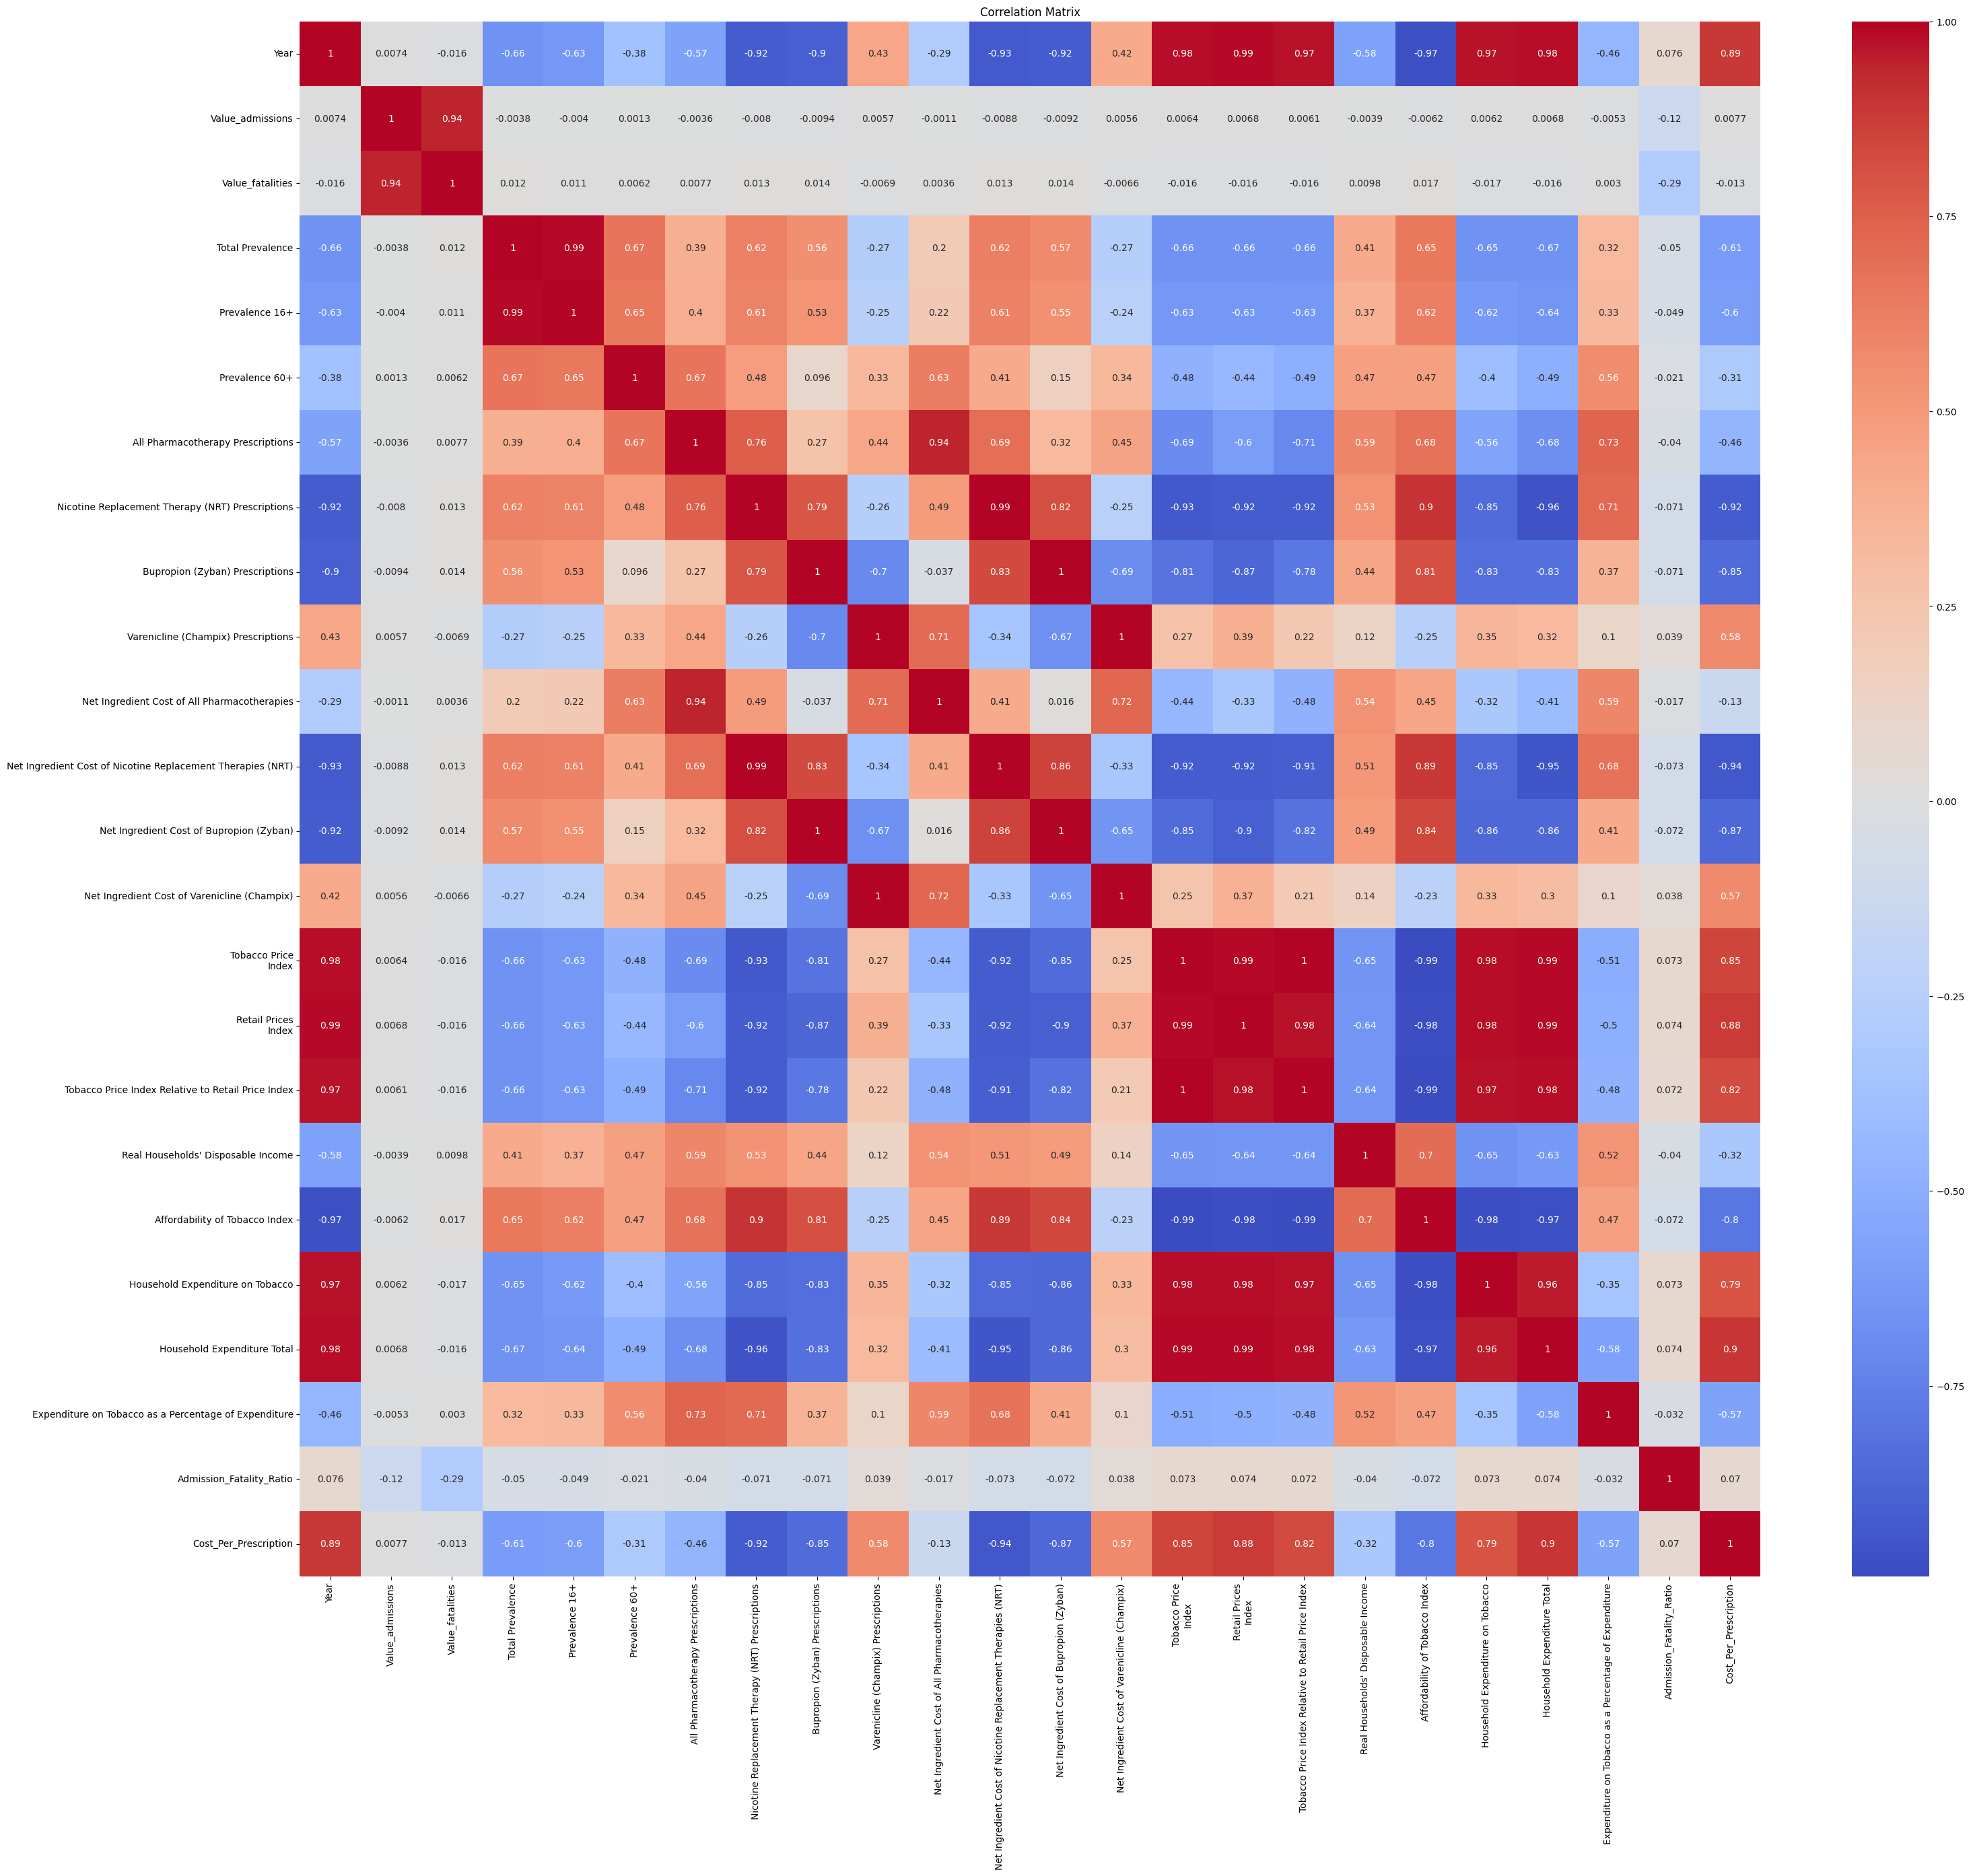

In [20]:
# Select only numeric columns for correlation
numeric_cols = final_df_cleaned.select_dtypes(include=['number'])

# Correlation heatmap
plt.figure(figsize=(35, 30))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [21]:
print(final_df_cleaned.columns)


Index(['Year', 'ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric',
       'Sex', 'Value_admissions', 'Value_fatalities', 'Total Prevalence',
       'Prevalence 16+', 'Prevalence 60+', 'All Pharmacotherapy Prescriptions',
       'Nicotine Replacement Therapy (NRT) Prescriptions',
       'Bupropion (Zyban) Prescriptions',
       'Varenicline (Champix) Prescriptions',
       'Net Ingredient Cost of All Pharmacotherapies',
       'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)',
       'Net Ingredient Cost of Bupropion (Zyban)',
       'Net Ingredient Cost of Varenicline (Champix)', 'Tobacco Price\nIndex',
       'Retail Prices\nIndex',
       'Tobacco Price Index Relative to Retail Price Index',
       'Real Households' Disposable Income', 'Affordability of Tobacco Index',
       'Household Expenditure on Tobacco', 'Household Expenditure Total',
       'Expenditure on Tobacco as a Percentage of Expenditure',
       'Admission_Fatality_Ratio', 'Cost_Per_Prescription']

In [23]:
print(X_train.isnull().sum())  # Count of NaN values per column
print(y_train.isnull().sum())


Total Prevalence                  0
Prevalence 16+                    0
Prevalence 60+                    0
Admission_Fatality_Ratio          0
Tobacco Price\nIndex              0
Affordability of Tobacco Index    0
Cost_Per_Prescription             0
dtype: int64
0


In [24]:
import numpy as np

print(np.isinf(X_train).sum())  # Count of infinite values per column
print(np.isinf(y_train).sum())


Total Prevalence                   0
Prevalence 16+                     0
Prevalence 60+                     0
Admission_Fatality_Ratio          44
Tobacco Price\nIndex               0
Affordability of Tobacco Index     0
Cost_Per_Prescription              0
dtype: int64
0


In [25]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
y_train.fillna(y_train.mean(), inplace=True)
y_test.fillna(y_test.mean(), inplace=True)


In [26]:
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]  # Ensure alignment


In [27]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)


In [28]:
print(X_train.dtypes)  # Check data types

# Convert object columns (if any) to numeric or drop them
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test = X_test.apply(pd.to_numeric, errors="coerce")


Total Prevalence                  float64
Prevalence 16+                      int64
Prevalence 60+                      int64
Admission_Fatality_Ratio          float64
Tobacco Price\nIndex              float64
Affordability of Tobacco Index    float64
Cost_Per_Prescription             float64
dtype: object


In [29]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [32]:
from sklearn.model_selection import train_test_split

X = final_df_cleaned.drop(columns=["Value_fatalities"])  # Exclude target column
y = final_df_cleaned["Value_fatalities"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Max value in the dataset: 1118992.0
Min value in the dataset: 0.0
Mean Squared Error: 5970.3725
R-squared Score: 0.9998236838815571


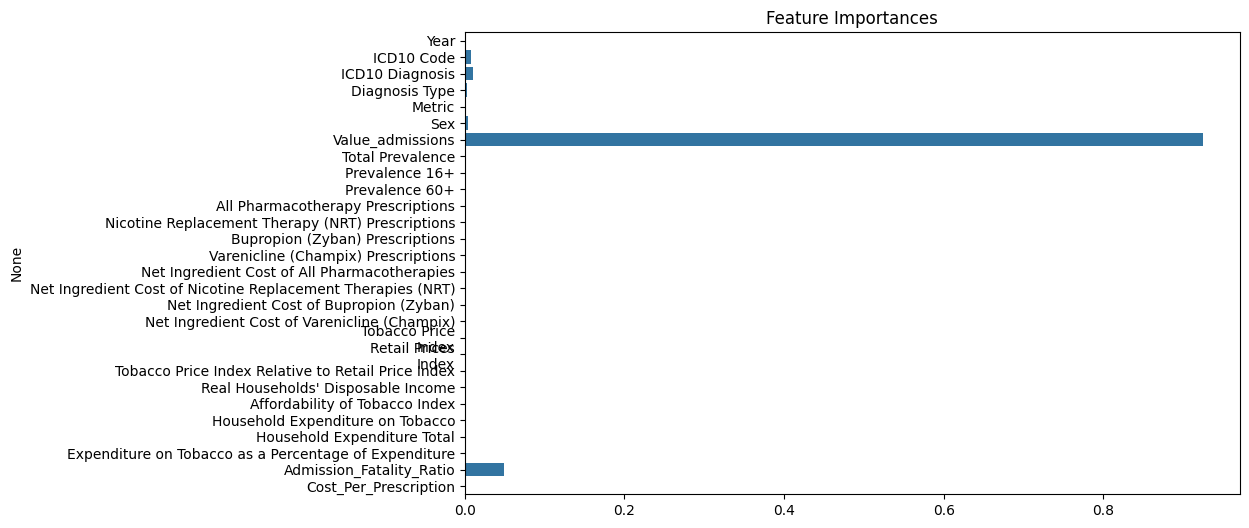

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Replace infinite values with NaN and fill them with the median
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# Check if there are any large values that need to be capped (optional)
# This can be useful if your data contains extreme outliers
max_value = X.max().max()
min_value = X.min().min()
print(f"Max value in the dataset: {max_value}")
print(f"Min value in the dataset: {min_value}")

# Optional: You can cap the values that exceed a certain threshold, for example:
cap_value = 1e6  # You can adjust this threshold as needed
X = X.clip(-cap_value, cap_value)

# Handle categorical columns - Option 1: Drop categorical columns (if any)
categorical_cols = X.select_dtypes(include=["object"]).columns
X_encoded = X.drop(columns=categorical_cols)

# OR Option 2: Apply Label Encoding to categorical columns (if applicable)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

# Now scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature Importances
importances = model.feature_importances_
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title("Feature Importances")
plt.show()


Mean Squared Error: 6591478.977003628
R-squared Score: 0.8053414610188461


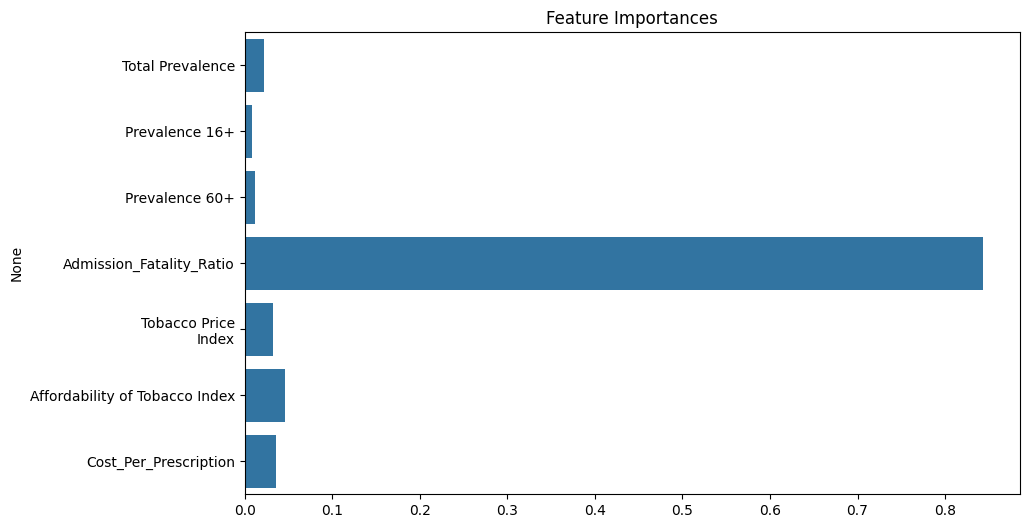

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming final_df_cleaned is your cleaned dataset
# Define the features (X) and the target variable (y)
X = final_df_cleaned[
    [
        "Total Prevalence",
        "Prevalence 16+",
        "Prevalence 60+",
        "Admission_Fatality_Ratio",
        "Tobacco Price\nIndex",
        "Affordability of Tobacco Index",
        "Cost_Per_Prescription",
    ]
]
y = final_df_cleaned["Value_fatalities"]

# Handle missing values if any
X = X.fillna(X.mean())  # Filling missing values with column mean
y = y.fillna(y.mean())  # Filling missing values in target with mean

# Check for infinity or large values in X
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
X = X.fillna(X.mean())  # Replace NaNs with column mean

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if there are any extremely large values that could cause issues
if (X_train > 1e10).any().any():
    print("Warning: There are very large values in the data.")

# Scale the features for better deep learning performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature Importances
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title("Feature Importances")
plt.show()

# Optional: Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Retrain the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Make predictions with the tuned model
y_pred_tuned = best_model.predict(X_test_scaled)

# Evaluate the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

# Print the evaluation metrics of the tuned model
print(f"Tuned Model - Mean Squared Error: {mse_tuned}")
print(f"Tuned Model - R-squared Score: {r2_tuned}")

# Feature Importances from the tuned model
importances_tuned = best_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_tuned, y=X.columns)
plt.title("Tuned Model - Feature Importances")
plt.show()

# You can also use SHAP or LIME for deeper model explainability if needed.
